In [40]:
import os 
import time
import uuid 
import cv2

In [44]:
IMAGES_PATH = os.path.join('data','images')
number_images = 60

In [45]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collection image {}'.format(imgnum))
    ret, frame = cap.read()

    if not ret:
        print("Erreur lors de la capture de l'image.")
        break

    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Collection image 0
Collection image 1
Collection image 2
Collection image 3
Collection image 4
Collection image 5
Collection image 6
Collection image 7
Collection image 8
Collection image 9
Collection image 10
Collection image 11
Collection image 12
Collection image 13
Collection image 14
Collection image 15
Collection image 16
Collection image 17
Collection image 18
Collection image 19
Collection image 20
Collection image 21
Collection image 22
Collection image 23
Collection image 24
Collection image 25
Collection image 26
Collection image 27
Collection image 28
Collection image 29
Collection image 30
Collection image 31
Collection image 32
Collection image 33
Collection image 34
Collection image 35
Collection image 36
Collection image 37
Collection image 38
Collection image 39
Collection image 40
Collection image 41
Collection image 42
Collection image 43
Collection image 44
Collection image 45
Collection image 46
Collection image 47
Collection image 48
Collection image 49
Collection

In [51]:
!labelme

2024-01-03 11:20:48,172 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\gbencheikh\.labelmerc


# Review dataset and build image loading function

## import tensorflow and deps

In [4]:
import tensorflow as tf
import cv2
import json
import numpy as np 
from matplotlib import pyplot as plt

## load image into TF Data Pipeline

In [5]:
images = tf.data.Dataset.list_files('data\\images\\*jpg', shuffle=False)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*jpg'

In [2]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [1]:
images = images.map(load_image)

NameError: name 'images' is not defined

## View Raw Images With Matplot

In [10]:
image_generator = images.batch(4).as_numpy_iterator()

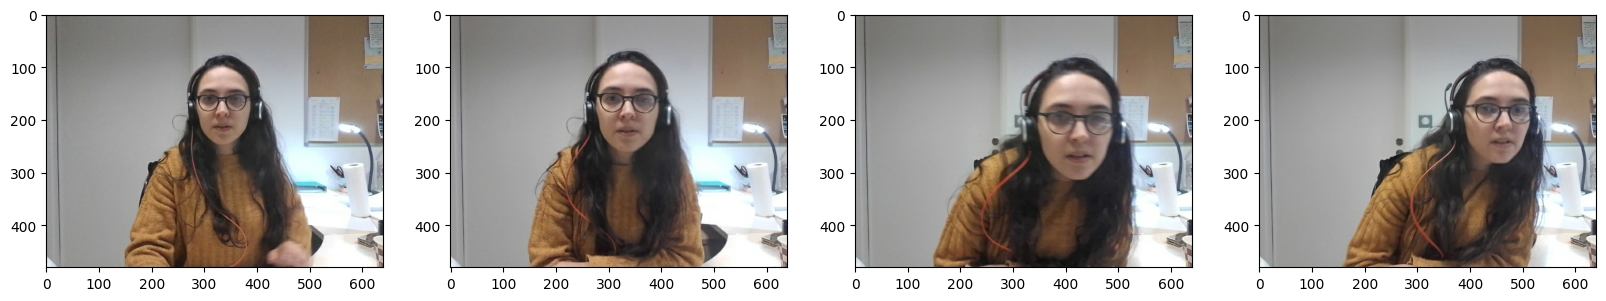

In [12]:
plot_images = image_generator.next()
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)

plt.show()

## Move the matching labels 

In [14]:
import os 
for folder in ['train','val','test']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)   
            os.replace(existing_filepath, new_filepath)            

# Data augmentation

In [15]:
import albumentations as alb

In [28]:
img = cv2.imread("data/test/images/69be2563-a95d-11ee-8108-00be4366c488.jpg")
img.shape

(480, 640, 3)

In [29]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightness(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations', 
                                                    label_fields=['class_labels']))

c:\Users\gbencheikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [30]:
img = cv2.imread(os.path.join('data','train','images','6aa95180-a95d-11ee-b5ea-00be4366c488.jpg'))

In [34]:
with open(os.path.join('data','train','labels','6aa95180-a95d-11ee-b5ea-00be4366c488.json'), 'r') as f:
    label = json.load(f)


In [38]:
label['shapes'][0]['points']

[[323.72340425531917, 120.85106382978725],
 [424.25531914893617, 252.2340425531915]]

In [40]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[323.72340425531917, 120.85106382978725, 424.25531914893617, 252.2340425531915]

In [41]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.5058178191489362,
 0.2517730496453901,
 0.6628989361702128,
 0.5254875886524822]

## Apply augmenttions and view results

In [47]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [45]:
augmented['bboxes']

[(0.4638297872340426,
  0.23744680851063835,
  0.6872340425531914,
  0.5294089834515366)]

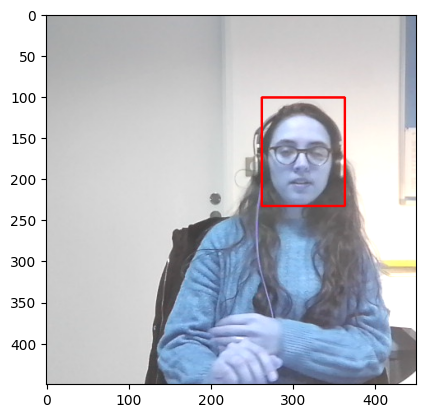

In [48]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

##  Run Augmentation Pipeline

In [50]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

## Load Augmented Images to Tensorflow Dataset

In [6]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

## Build labels to Tensorflow Dataset

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [8]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

## Combinelabels and image samples 

## Check partitions lengths

In [9]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

In [10]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

# View Images and annotations

In [12]:
data_samples = train.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


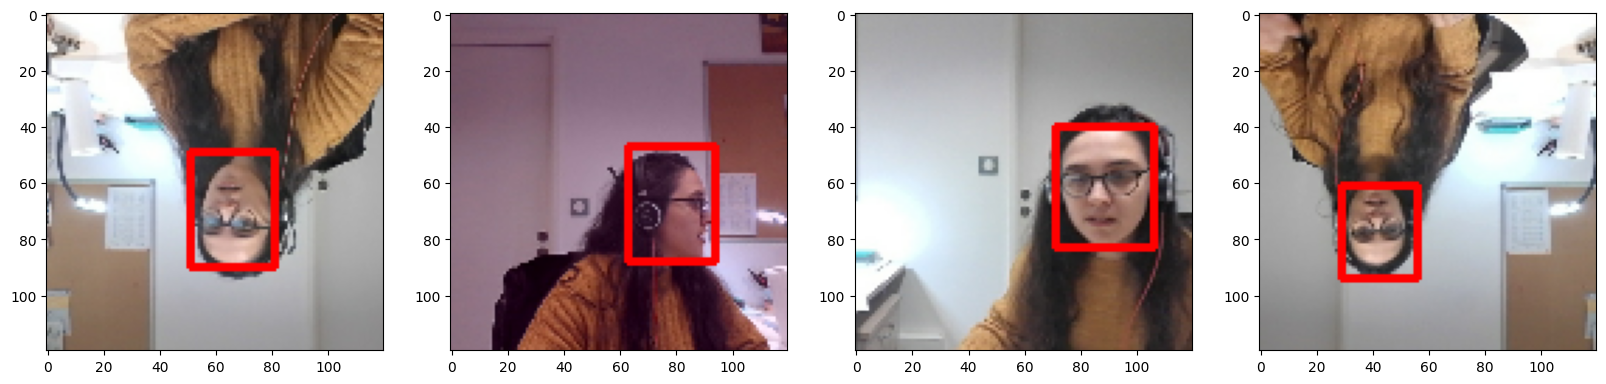

In [13]:
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Build Deep Learning using the Functional API

## Import layers and base network

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## Download VGG16

In [15]:
vgg = VGG16(include_top=False)
vgg.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

## Build network

In [16]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [17]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [19]:
X, y = train.as_numpy_iterator().next()
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 185ms/step


# Define Losses and Optimizers

## Define Optimizer and LR

In [21]:
batches_per_epoch = len(train)

# Learning Rate Scheduler
initial_learning_rate = 0.0001
learning_decay = (1./0.75 - 1)/batches_per_epoch

In [23]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

## Create Localization Loss and Classification Loss

In [24]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [25]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## Test Loss Metrics

In [26]:
localization_loss(y[1], coords)
classloss(y[0], classes)
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.837635>

# Train Neural Network

In [27]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [28]:
model = FaceTracker(facetracker)

In [29]:
model.compile(optimizer, classloss, regressloss)

In [30]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


473/473 [==============================] - 550s 1s/step - total_loss: 0.3041 - class_loss: 0.1097 - regress_loss: 0.2493 - val_total_loss: 0.1596 - val_class_loss: 0.1424 - val_regress_loss: 0.0884
Epoch 2/10
473/473 [==============================] - 548s 1s/step - total_loss: 0.0590 - class_loss: 0.0173 - regress_loss: 0.0504 - val_total_loss: 0.0115 - val_class_loss: 0.0029 - val_regress_loss: 0.0100
Epoch 3/10
473/473 [==============================] - 536s 1s/step - total_loss: 0.0516 - class_loss: 0.0189 - regress_loss: 0.0421 - val_total_loss: 0.0057 - val_class_loss: 2.1491e-04 - val_regress_loss: 0.0056
Epoch 4/10
473/473 [==============================] - 588s 1s/step - total_loss: 0.0370 - class_loss: 0.0091 - regress_loss: 0.0324 - val_total_loss: 0.0049 - val_class_loss: 7.9682e-05 - val_regress_loss: 0.0049
Epoch 5/10
473/473 [==============================] - 547s 1s/step - total_loss: 0.0490 - class_loss: 0.0170 - regress_loss: 0.0404 - val_total_loss: 0.0128 - val_clas

In [32]:
hist.history

{'total_loss': [0.019273634999990463,
  0.014220619574189186,
  0.009915503673255444,
  0.008476302027702332,
  0.008247395046055317,
  0.008564146235585213,
  0.009275785647332668,
  0.004735012538731098,
  0.0043912483379244804,
  0.016773970797657967],
 'class_loss': [0.011815913952887058,
  0.0007965608965605497,
  0.00014844635734334588,
  6.591281271539629e-05,
  0.0007874591974541545,
  1.4260560419643298e-05,
  3.501781520753866e-06,
  0.00012752194015774876,
  1.3932767615187913e-05,
  7.454353908542544e-05],
 'regress_loss': [0.013365678489208221,
  0.013822339475154877,
  0.009841280058026314,
  0.008443345315754414,
  0.007853665389120579,
  0.008557016029953957,
  0.009274034760892391,
  0.004671251401305199,
  0.004384282045066357,
  0.016736699268221855],
 'val_total_loss': [0.1595759391784668,
  0.011498861946165562,
  0.005709110293537378,
  0.00491969333961606,
  0.012803898192942142,
  0.006918537430465221,
  0.009496024809777737,
  0.0022169447038322687,
  0.0061725

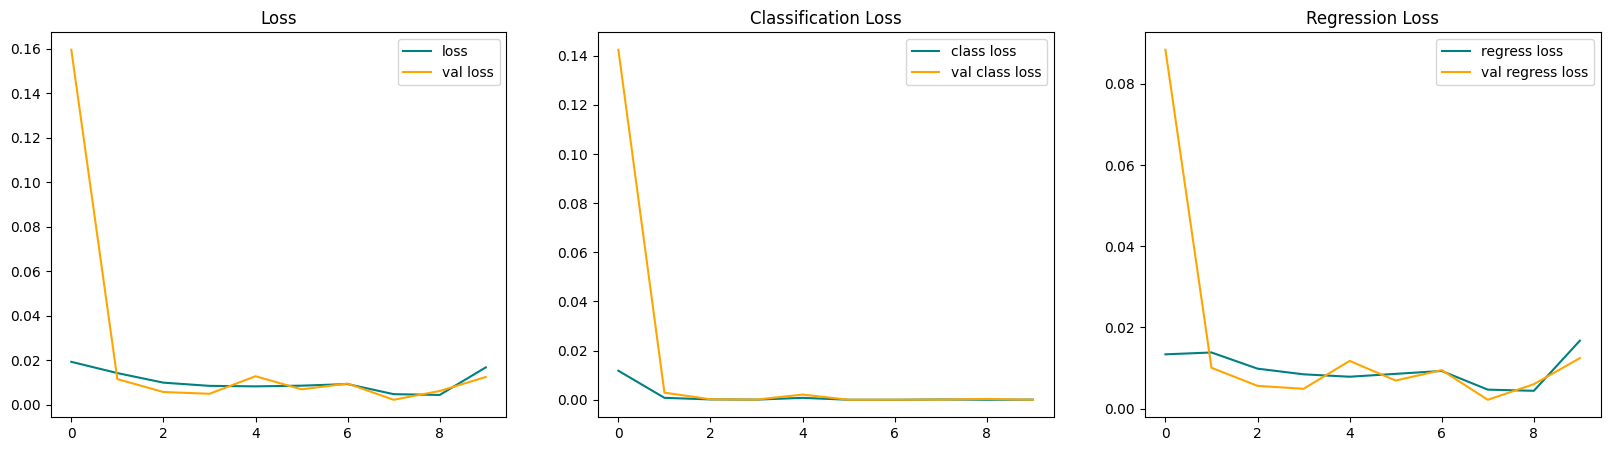

In [33]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Test model using test dataset

In [34]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 205ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.75744265 0.2656041  0.96217567 0.5989023 ]
[0.7414823  0.27016613 0.9511389  0.61595666]
[0.49203143 0.41231698 0.7672763  0.7750523 ]
[0.7621933  0.4091463  0.95255905 0.7013416 ]


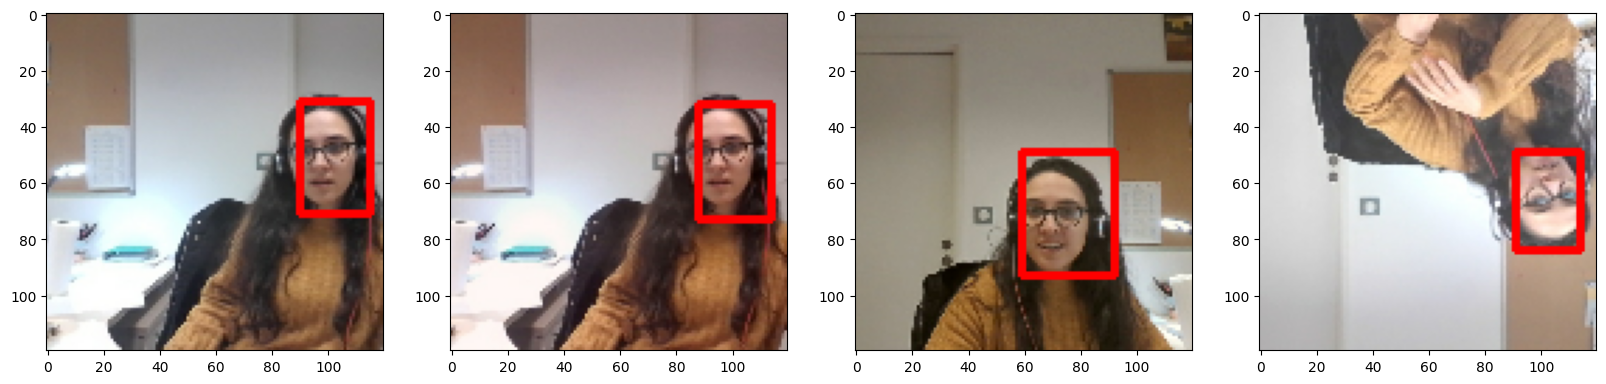

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx]

    print(sample_coords)     

    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## Save model

In [8]:
import tensorflow as tf 
from tensorflow.keras.models import load_model
import cv2
from tensorflow.keras.models import load_model
import numpy as np 

facetracker.save('facetracker.h5')

c:\Users\gbencheikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Real time Detection

In [9]:
facetracker = load_model('facetracker.h5')

cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, f"face{yhat[0]}", tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 72ms/step
